RNN 미완성

Epoch [10/100], Loss: 0.0177
Epoch [20/100], Loss: 0.0162
Epoch [30/100], Loss: 0.0124
Epoch [40/100], Loss: 0.0108
Epoch [50/100], Loss: 0.0086
Epoch [60/100], Loss: 0.0041
Epoch [70/100], Loss: 0.0052
Epoch [80/100], Loss: 0.0133
Epoch [90/100], Loss: 0.0033
Epoch [100/100], Loss: 0.0126


C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\Owner\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 50900 missing from current font.
  font.set_text(s, 0, flags=flags)


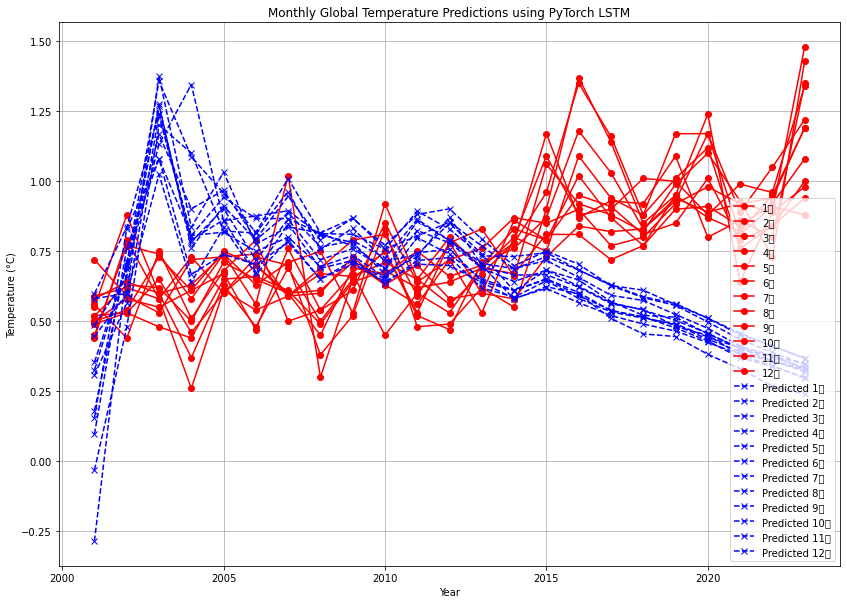

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler


# 데이터 불러오기
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
df = pd.read_csv(url, skiprows=1)

# ***을 NaN으로 대체
df.replace('***', np.nan, inplace=True)

# 필요한 열만 선택 (월별 평균 기온 데이터)
data = df.iloc[:, 1:13].astype(float)

# NaN 값 처리: 평균으로 대체
data = data.fillna(data.mean())

# 데이터 스케일링 (0~1 사이 값으로 조정)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터를 시계열 형태로 변환
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps-1):
        X.append(data[i:(i+n_steps)])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# 입력 시퀀스 길이 설정 (예: 10년치 데이터를 기반으로 다음 해 데이터 예측)
n_steps = 10
X, y = create_sequences(scaled_data, n_steps)

# PyTorch를 위해 데이터를 Tensor로 변환
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# 데이터셋과 데이터로더 생성
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False)


class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # LSTM의 마지막 시간 단계 출력을 사용하여 예측
        return out

# 모델 초기화
input_size = 12  # 입력 데이터의 특성 수 (월별 평균 기온)
hidden_size = 50  # LSTM의 hidden state 크기
output_size = 12  # 출력 데이터의 특성 수 (월별 평균 기온)

model = LSTMModel(input_size, hidden_size, output_size)

# 손실 함수와 최적화 기법 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

        
# 예측을 위해 마지막 n_steps만큼 데이터 추출
last_sequence = scaled_data[-n_steps:]
last_sequence = torch.from_numpy(last_sequence).float().unsqueeze(0)

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
predicted_data = []
for i in range(23):  # 2001년부터 2023년까지의 예측을 수행
    with torch.no_grad():
        output = model(last_sequence)
        predicted_data.append(output.numpy()[0])

    # 예측 결과를 다음 입력으로 사용
    last_sequence = torch.cat((last_sequence[:, 1:, :], output.unsqueeze(0)), dim=1)

# 스케일 역변환
predicted_data = scaler.inverse_transform(predicted_data)

# 실제 데이터
actual_data = data.iloc[121:144].values

# 예측 결과 시각화
years = range(2001, 2024)
months = range(1, 13)

plt.figure(figsize=(14, 10))

# 실제 데이터 (빨강색)
for i in range(12):
    plt.plot(years, actual_data[:, i], marker='o', linestyle='-', color='r', label=f'{months[i]}월')

# 예측 데이터 (파랑색)
for i in range(12):
    plt.plot(years, predicted_data[:, i], marker='x', linestyle='--', color='b', label=f'Predicted {months[i]}월')

plt.title('Monthly Global Temperature Predictions using PyTorch LSTM')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


C:\Users\Owner\anaconda3\lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [10/100], Loss: 0.0025
Epoch [20/100], Loss: 0.0033
Epoch [30/100], Loss: 0.0036
Epoch [40/100], Loss: 0.0039
Epoch [50/100], Loss: 0.0039
Epoch [60/100], Loss: 0.0037
Epoch [70/100], Loss: 0.0037
Epoch [80/100], Loss: 0.0084
Epoch [90/100], Loss: 0.0066
Epoch [100/100], Loss: 0.0063


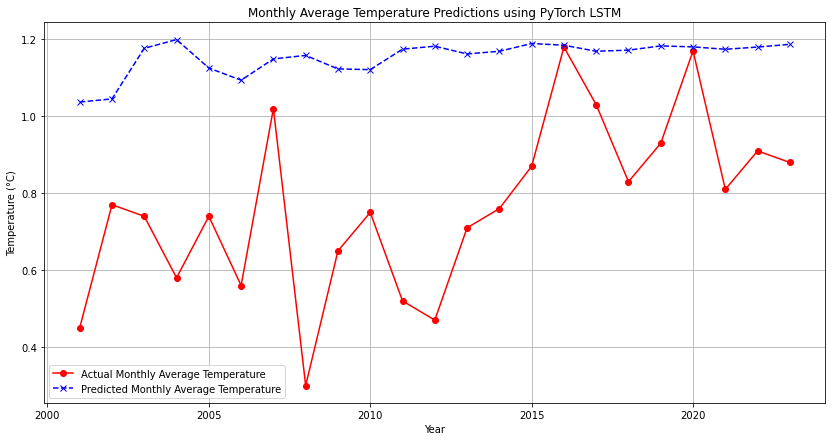

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler

# 데이터 불러오기
url = 'https://data.giss.nasa.gov/gistemp/tabledata_v4/GLB.Ts+dSST.csv'
df = pd.read_csv(url, skiprows=1)

# ***을 NaN으로 대체
df.replace('***', np.nan, inplace=True)

# 필요한 열만 선택 (월별 평균 기온 데이터)
data = df.iloc[:, 1:13].astype(float)

# NaN 값 처리: 평균으로 대체
data = data.fillna(data.mean())

# 데이터 스케일링 (0~1 사이 값으로 조정)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# 데이터를 시계열 형태로 변환 (단일 월 평균 기온 예측)
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data)-n_steps-1):
        X.append(data[i:(i+n_steps)])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# 입력 시퀀스 길이 설정 (예: 10년치 데이터를 기반으로 다음 해 데이터 예측)
n_steps = 10
X, y = create_sequences(scaled_data[:, 0], n_steps)  # 첫 번째 월의 데이터만 사용

# PyTorch를 위해 데이터를 Tensor로 변환
X_tensor = torch.from_numpy(X).unsqueeze(-1).float()  # LSTM 모델 입력 형태로 차원 추가
y_tensor = torch.from_numpy(y).float()

# 데이터셋과 데이터로더 생성
dataset = TensorDataset(X_tensor, y_tensor)
train_loader = DataLoader(dataset, batch_size=1, shuffle=False)

# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # LSTM의 마지막 시간 단계 출력을 사용하여 예측
        return out

# 모델 초기화
input_size = 1  # 입력 데이터의 특성 수 (월평균 기온 하나)
hidden_size = 50  # LSTM의 hidden state 크기
output_size = 1  # 출력 데이터의 특성 수 (월평균 기온 하나)

model = LSTMModel(input_size, hidden_size, output_size)

# 손실 함수와 최적화 기법 설정
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# 모델 훈련
num_epochs = 100
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# 예측을 위해 마지막 n_steps만큼 데이터 추출
last_sequence = scaled_data[-n_steps:, 0]  # 마지막 n_steps 개월의 첫 번째 월 데이터
last_sequence = torch.from_numpy(last_sequence).unsqueeze(-1).float().unsqueeze(0)

# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
predicted_data = []
for i in range(23):  # 2001년부터 2023년까지의 예측을 수행
    with torch.no_grad():
        output = model(last_sequence)
        predicted_data.append(output.numpy()[0][0])  # 첫 번째 월의 예측 값만 추출

    # 예측 결과를 다음 입력으로 사용
    last_sequence = torch.cat((last_sequence[:, 1:, :], output.unsqueeze(0)), dim=1)

# 스케일 역변환을 위해 예측 데이터를 12개월로 확장
predicted_data_extended = np.repeat(np.array(predicted_data).reshape(-1, 1), 12, axis=1)

# 스케일 역변환
predicted_data = scaler.inverse_transform(predicted_data_extended)

# 실제 데이터 (마지막 23년간)
actual_data = data.iloc[121:144, 0].values.reshape(-1, 1)

# 예측 결과 시각화
years = range(2001, 2024)

plt.figure(figsize=(14, 7))

# 실제 데이터 (빨강색)
plt.plot(years, actual_data, marker='o', linestyle='-', color='r', label='Actual Monthly Average Temperature')

# 예측 데이터 (파랑색)
plt.plot(years, predicted_data[:, 0], marker='x', linestyle='--', color='b', label='Predicted Monthly Average Temperature')

plt.title('Monthly Average Temperature Predictions using PyTorch LSTM')
plt.xlabel('Year')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
print(df)

     Year   Jan   Feb   Mar   Apr   May   Jun   Jul   Aug   Sep   Oct   Nov  \
0    1880 -0.19 -0.24 -0.09 -0.16 -0.10 -0.21  -.18  -.10  -.14  -.23  -.21   
1    1881 -0.20 -0.14  0.03  0.05  0.06 -0.19   .00  -.04  -.16  -.22  -.18   
2    1882  0.16  0.13  0.04 -0.17 -0.14 -0.23  -.17  -.07  -.14  -.24  -.17   
3    1883 -0.29 -0.37 -0.12 -0.18 -0.17 -0.08  -.07  -.14  -.21  -.11  -.23   
4    1884 -0.13 -0.08 -0.36 -0.40 -0.34 -0.35  -.31  -.28  -.27  -.25  -.34   
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
140  2020  1.17  1.24  1.17  1.12  1.01  0.91   .89   .87   .98   .88  1.10   
141  2021  0.81  0.64  0.89  0.76  0.79  0.84   .92   .82   .92   .99   .93   
142  2022  0.91  0.89  1.05  0.84  0.84  0.92   .94   .95   .89   .96   .73   
143  2023  0.88  0.98  1.22  1.00  0.94  1.08  1.19  1.19  1.48  1.34  1.43   
144  2024  1.22  1.43  1.40  1.32  1.16  1.21   NaN   NaN   NaN   NaN   NaN   

      Dec   J-D   D-N   DJF   MAM   JJA   SON  
0  